In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dahoua","key":"ff728d93530403308b3ef623577e0fca"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
! kaggle competitions download -c text-normalization-challenge-english-language

In [9]:
! mkdir input

In [ ]:
! unzip en_train.csv.zip -d input

In [11]:
from __future__ import unicode_literals, print_function, division

from io import open
import unicodedata
import string
import re
import random

import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
import torch
torch.cuda.is_available()

True

In [13]:
df = pd.read_csv('input/en_train.csv',encoding='utf-8')


In [14]:
df = df[df['class']=='DATE']

In [ ]:
df.head(30)

In [16]:
MAX_LENGTH = df.after.str.len().max()
MAX_LENGTH

61

In [17]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.char2index = {}
        self.char2count = {}
        self.index2char = {0: "SOS", 1: "EOS"}
        self.n_chars = 2  # Count SOS and EOS

    def add_sentence(self, sentence):
        for char in sentence:
            self.add_char(char)

    def add_char(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

In [18]:
def readLangs(df,lang1, lang2, reverse=False):
    pairs = [[a,b] for b,a in zip(df[lang1],df[lang2])]
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [19]:
def prepareData(df,lang1, lang2, reverse=False):
    MAX_LENGTH = df[lang2].str.len().max()
    input_lang, output_lang, pairs = readLangs(df,lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting chars...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted chars:")
    print(input_lang.name, input_lang.n_chars)
    print(output_lang.name, output_lang.n_chars)
    return input_lang, output_lang, pairs

In [20]:
input_lang, output_lang, pairs = prepareData(df,'before', 'after', True)
print(random.choice(pairs))

Read 258348 sentence pairs
Counting chars...
Counted chars:
after 62
before 26
['16 September 2010', 'the sixteenth of september twenty ten']


In [21]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size) # embedding_size (vocab_size), embedding_dim
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [22]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [23]:
def indexesFromSentence(lang, sentence):
    return [lang.char2index[char] for char in sentence]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [24]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [25]:
# This is a helper function to print time elapsed and estimated time
# remaining given the current time and progress %.
#

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [26]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [27]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


In [28]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_chars = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_chars.append('<EOS>')
                break
            else:
                decoded_chars.append(output_lang.index2char[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_chars, decoder_attentions[:di + 1]

4m 12s (- 4m 12s) (5000 50%) 1.2578
8m 32s (- 0m 0s) (10000 100%) 0.6876


<Figure size 432x288 with 0 Axes>

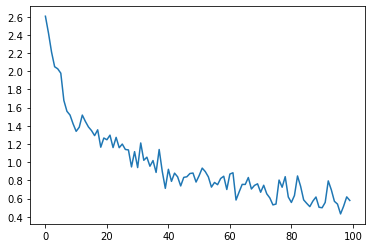

In [29]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_chars, hidden_size).to(device) # Size of the vocabulary, i.e. maximum integer index + 1.
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_chars, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=5000)

In [30]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        print('<', output_sentence)
        print('')

In [31]:
evaluateRandomly(encoder1, attn_decoder1)

> 2 February 2011
= the second of february twenty eleven
< the twenty fi t of aurtetwenty tleven<EOS>

> 22 August 2007
= the twenty second of august two thousand seven
< the twenty seo of ou o twoo ust ouse o seven<EOS>

> 2009
= two thousand nine
< two thousand nine<EOS>

> 1963
= nineteen sixty three
< nineteen sixty three<EOS>

> 1996
= nineteen ninety six
< nineteen ninety six<EOS>

> 2011
= twenty eleven
< twenty eleven<EOS>

> 2011
= twenty eleven
< twenty eleven<EOS>

> 1938
= nineteen thirty eight
< nineteen thirty eight<EOS>

> 1959
= nineteen fifty nine
< nineteen fifty five<EOS>

> 2005
= two thousand five
< two thousand five<EOS>



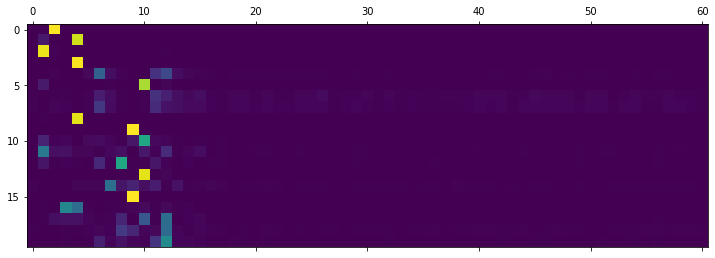

In [32]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "6")
plt.matshow(attentions.numpy())

In [33]:
def plot_head_map(mma, target_labels, source_labels):
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(mma, cmap=plt.cm.Blues)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(mma.shape[1])+0.5, minor=False)
    ax.set_yticks(np.arange(mma.shape[0])+0.5, minor=False)


    # without this I get some extra columns rows
    # http://stackoverflow.com/questions/31601351/why-does-this-matplotlib-heatmap-have-an-extra-blank-column
    ax.set_xlim(0, len(source_labels)+2)
    ax.set_ylim(0, len(target_labels)+1)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # source words -> column labels
    ax.set_xticklabels(['']+list(source_labels), minor=False)
    # target words -> row labels
    ax.set_yticklabels(list(target_labels), minor=False)

    plt.yticks(rotation=90)
    plt.show()

input = 3 March 2014
output = t h e   t h i r d   o f   m a y   t w e n t y   t h i r t e e n <EOS>


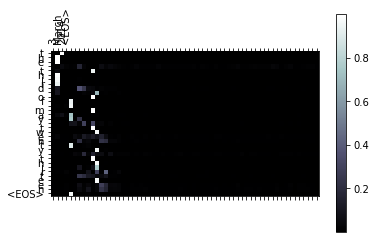

In [41]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention("3 March 2014")


input = 4 March 2014
output = the fourteenth of may twenty twelve<EOS>
torch.Size([36, 61])


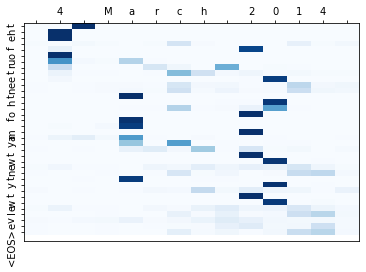

In [42]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ''.join(output_words))
    print(attentions.shape)
    plot_head_map(attentions,output_words,input_sentence)

evaluateAndShowAttention("4 March 2014")